<a href="https://colab.research.google.com/github/Jung0Jin/Pytorch_study/blob/master/2_%EC%84%A0%ED%98%95%ED%9A%8C%EA%B7%80%ED%99%9C%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2.선형회귀활용

공부한 선형회귀를 활용해보자.

##2.1데이터 다운로드

아래 링크 클릭하면 구글 드라이브에 저장된 데이터가 있다. 눌러서 다운로드 받으면 된다. 

출처 : https://dacon.io/competitions/open/235576/overview/

https://drive.google.com/open?id=1Fr-DRWYo4HqI9Rz57j5Bi16SVkSt7rPA #train.csv

https://drive.google.com/open?id=1Jm6ZoJGrC10-P2GK965Nd0vc0NAs07Sx #test.csv

https://drive.google.com/open?id=16SI0RPmqyBnOn-bZqtUv95NKKsLJcpS5 #submission.csv


##2.2 데이터 불러오기

*   데이터 설명

>2017년 4월 1일부터, 5월 31일까지 시간별로 서울시 따릉이 대여수와 기상상황 데이터가 주어집니다. 각 날짜의 1시간 전의 기상상황을 가지고 1시간 후의 따릉이 대여수를 예측해보세요. 

*   특징 데이터 (10개)

> id : 고유 id

> hour : 시간

> temperature : 기온

> precipitation : 비가 오지 않았으면 0, 비가 오면 1

> windspeed : 풍속(평균)

> humidity : 습도

> visibility : 가시 거리

> ozone : 오존

> pm10 : 미세먼지

> pm2.5 : 미세먼지

* 타겟 데이터 (1개)

> count : 시간에 따른 따릉이 대여 수

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#한글 출력 설정
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
import matplotlib as mpl 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
train = pd.read_csv('/content/drive/My Drive/데이콘 따릉이 데이터/train.csv')
train.fillna(train.mean(), inplace=True)
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [0]:
test = pd.read_csv('/content/drive/My Drive/데이콘 따릉이 데이터/test.csv')
test.fillna(test.mean(), inplace=True)
test.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


In [0]:
print(train.shape, test.shape)

(1459, 11) (715, 10)


In [0]:
train.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.235555,0.174797,1.374005,20.356410,582.731618,0.018994,30.774814,14.110562,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,880.000000,0.026000,37.000000,21.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.400000,51.000000,1576.000000,0.039149,53.000000,28.000000,96.000000
75%,1651.000000,17.500000,20.050000,0.000000,3.400000,68.500000,1994.000000,0.051000,68.000000,36.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


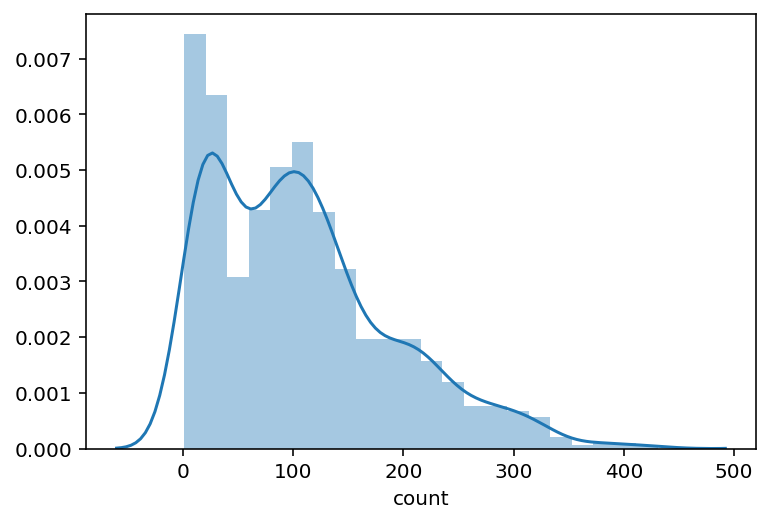

In [0]:
# count 값의 분포를 확인하자.
sns.distplot(train['count'])

In [0]:
# count 값 중 이상치를 제외시킨다.
# IQR = Q3-Q1 이다. Q1-(1.5*IQR) 보다 작거나, Q3+(1.5*IQR)보다 크면 이상치로 볼 수 있다.

temp=train['count'].values
q1 = np.percentile(temp, 25)
q3 = np.percentile(temp, 75)
iqr = q3-q1
print(q1-iqr*1.5)
print(q3+iqr*1.5)


-132.5
319.5


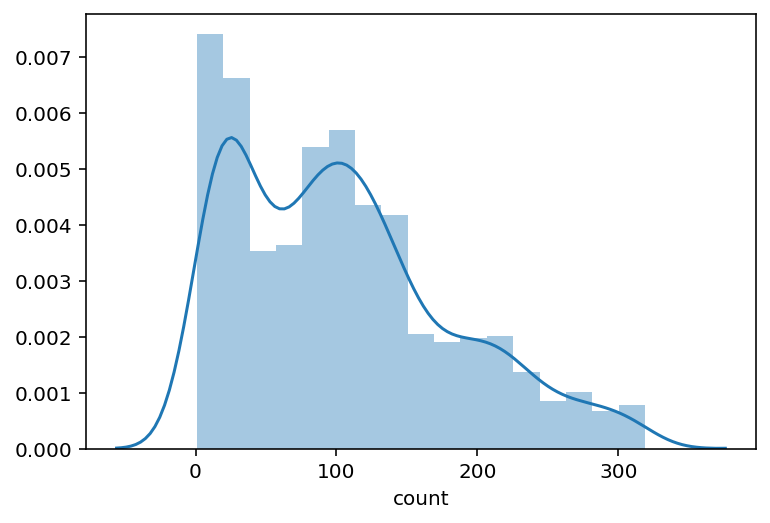

In [0]:
# 319.5 보다 큰 값은 이상치로 보이므로 지우겠다.
train = train[train['count']<q3+iqr*1.5]
sns.distplot(train['count'])

In [0]:
# 상관관계를 확인하자.
train.corr()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
id,1.000000,-0.008108,0.003231,-0.057448,0.003874,-0.026223,0.015976,0.057215,-0.030530,-0.003905,0.011063
hour,-0.008108,1.000000,0.395551,0.024380,0.454815,-0.320500,0.167067,0.360112,-0.028371,-0.052034,0.635935
hour_bef_temperature,0.003231,0.395551,1.000000,-0.094747,0.363864,-0.485955,0.185481,0.514197,0.004772,-0.069711,0.602330
hour_bef_precipitation,-0.057448,0.024380,-0.094747,1.000000,0.026296,0.276727,-0.216394,-0.057810,-0.049762,0.003195,-0.168228
hour_bef_windspeed,0.003874,0.454815,0.363864,0.026296,1.000000,-0.423090,0.241311,0.505478,0.017403,-0.184920,0.446111
hour_bef_humidity,-0.026223,-0.320500,-0.485955,0.276727,-0.423090,1.000000,-0.589359,-0.401610,-0.114203,0.152419,-0.460279
hour_bef_visibility,0.015976,0.167067,0.185481,-0.216394,0.241311,-0.589359,1.000000,0.090078,-0.386198,-0.610812,0.284057
hour_bef_ozone,0.057215,0.360112,0.514197,-0.057810,0.505478,-0.401610,0.090078,1.000000,0.119325,0.019924,0.448136
hour_bef_pm10,-0.030530,-0.028371,0.004772,-0.049762,0.017403,-0.114203,-0.386198,0.119325,1.000000,0.471372,-0.099186
hour_bef_pm2.5,-0.003905,-0.052034,-0.069711,0.003195,-0.184920,0.152419,-0.610812,0.019924,0.471372,1.000000,-0.118022


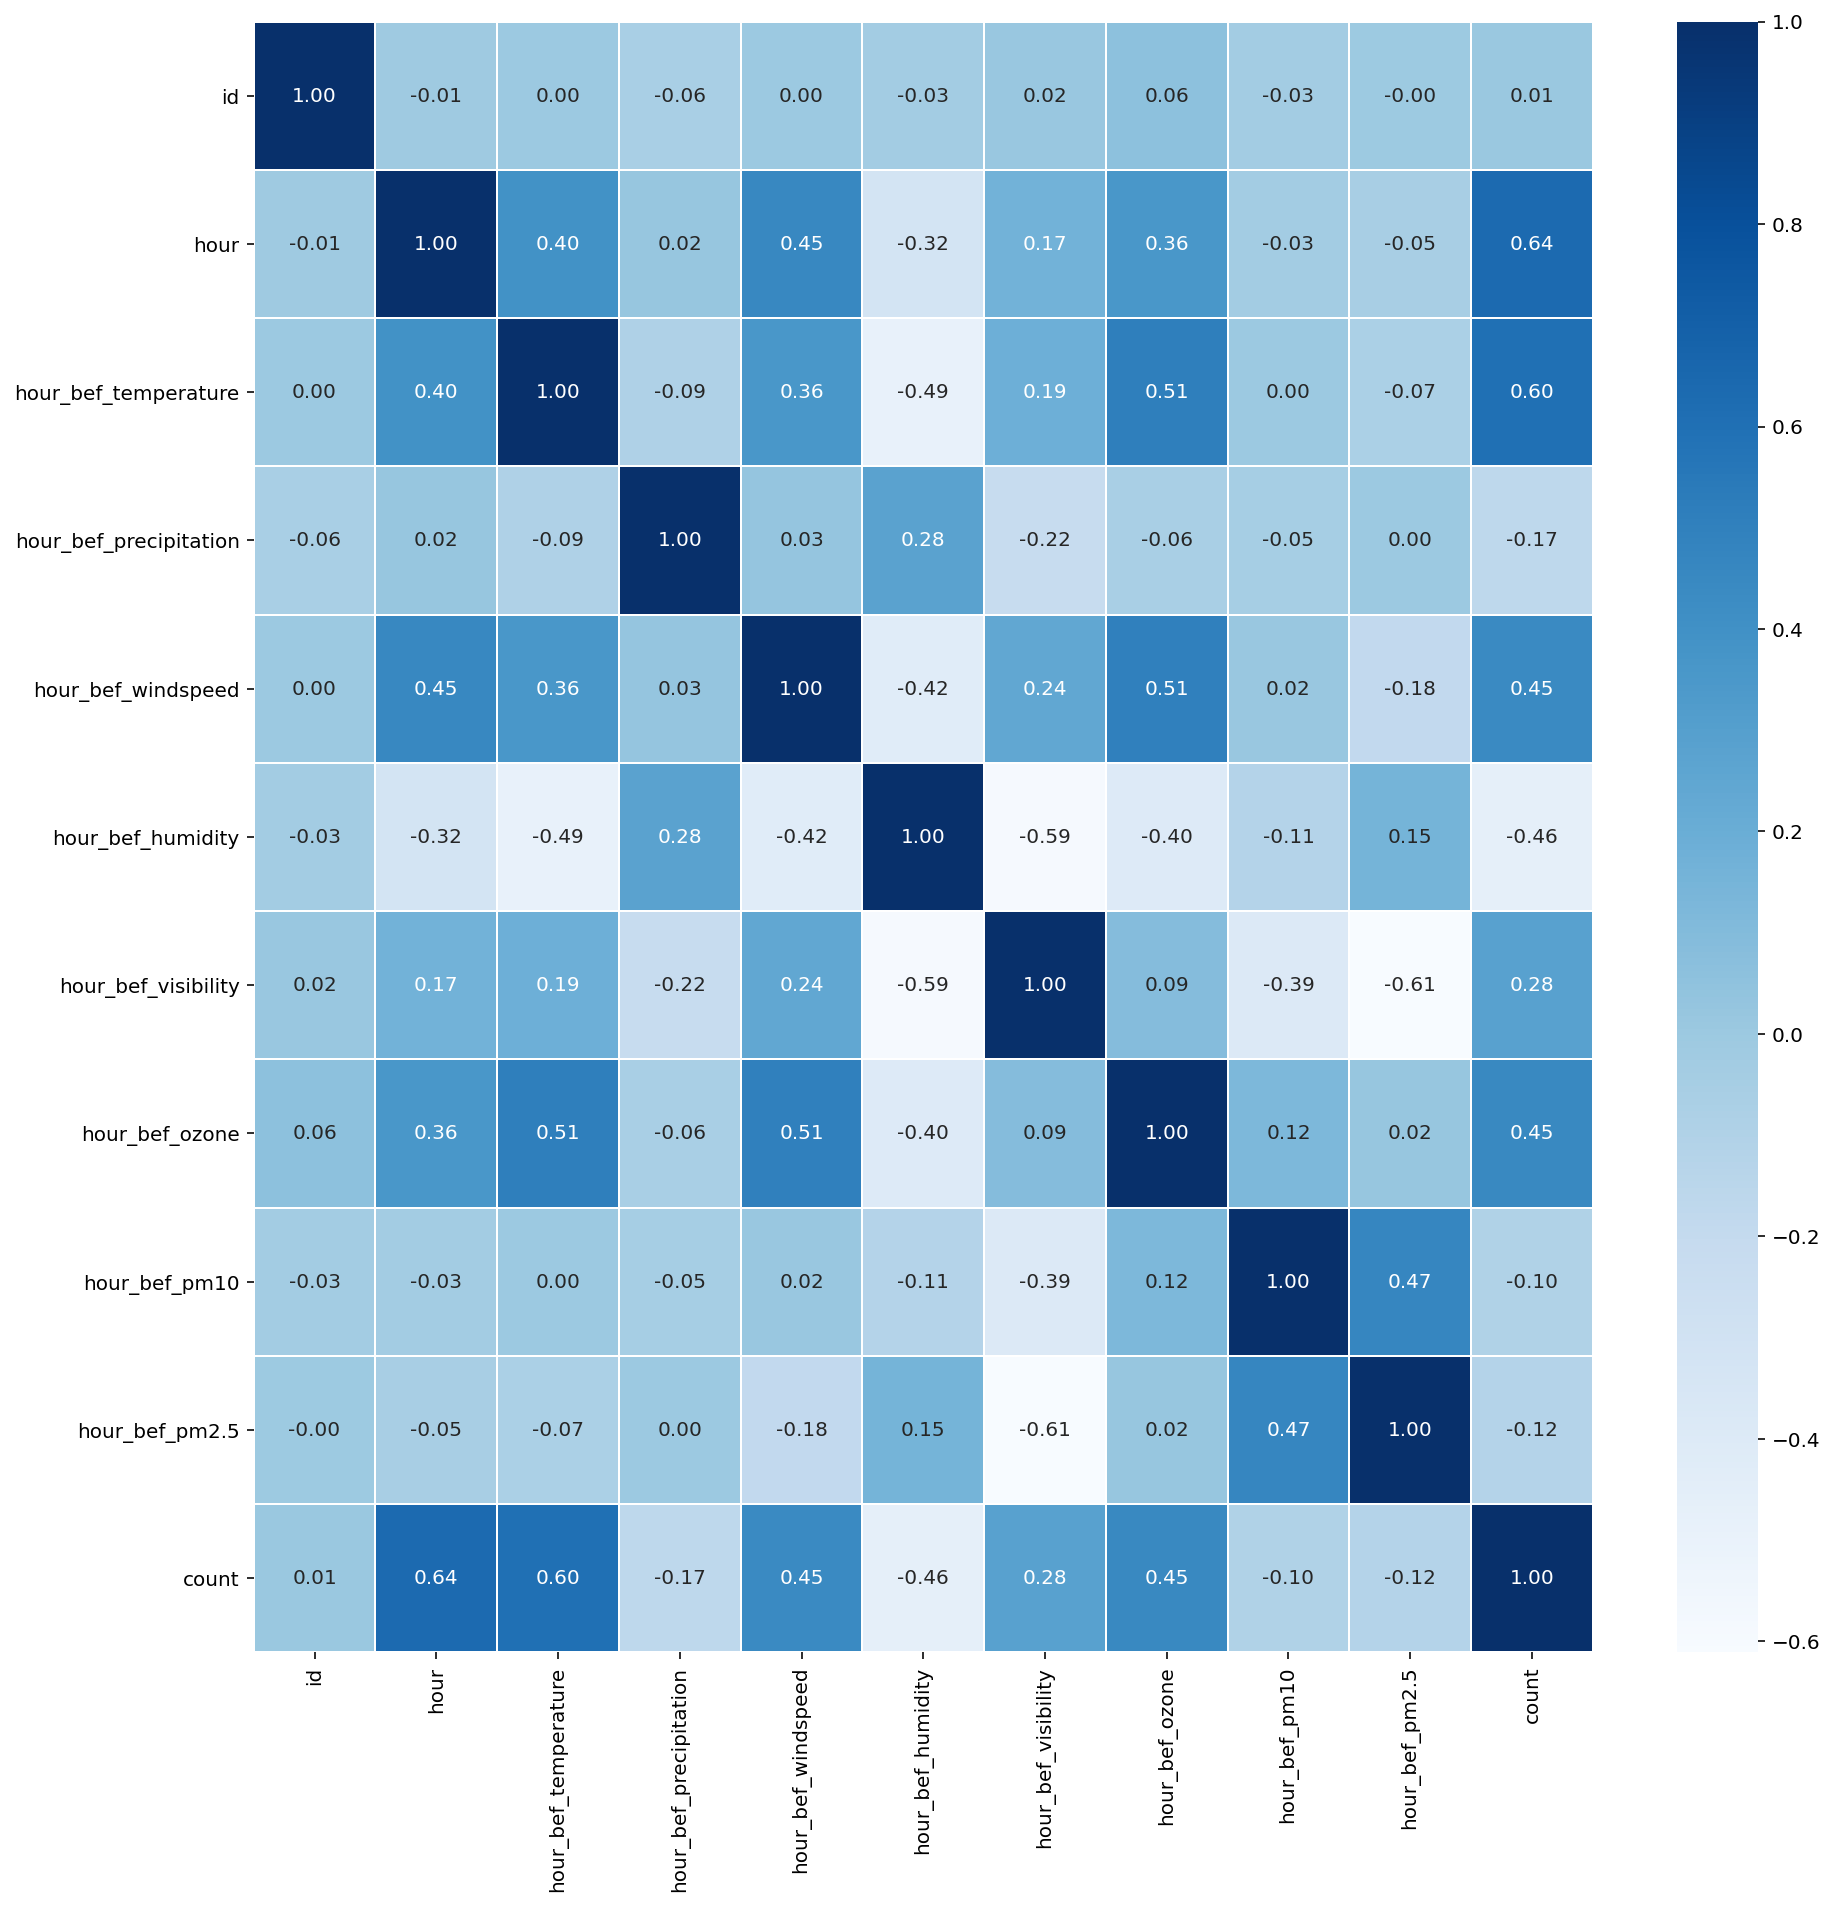

In [0]:
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

r이 -1.0과 -0.7 사이이면, 강한 음적 선형관계,

r이 -0.7과 -0.3 사이이면, 뚜렷한 음적 선형관계,

r이 -0.3과 -0.1 사이이면, 약한 음적 선형관계,

r이 -0.1과 +0.1 사이이면, 거의 무시될 수 있는 선형관계,

r이 +0.1과 +0.3 사이이면, 약한 양적 선형관계,

r이 +0.3과 +0.7 사이이면, 뚜렷한 양적 선형관계,

r이 +0.7과 +1.0 사이이면, 강한 양적 선형관계


In [0]:
# 상관계수의 절댓값이 0.1 보다 낮은 특성을 찾자.
temp = []
for i, v in enumerate(train.corr()['count']):
  if abs(v) < 0.1:
    temp.append(train.corr()['count'].index[i])
temp

['id', 'hour_bef_pm10']

In [0]:
# 상관계수의 절대값이 0.1 보다 낮은 특성은 버리자.
train = train.drop(temp, axis=1)
train.head()

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm2.5,count
0,20,16.3,1.0,1.5,89.0,576.0,0.027,33.0,49.0
1,13,20.1,0.0,1.4,48.0,916.0,0.042,40.0,159.0
2,6,13.9,0.0,0.7,79.0,1382.0,0.033,19.0,26.0
3,23,8.1,0.0,2.7,54.0,946.0,0.040,64.0,57.0
5,2,13.6,0.0,1.7,80.0,1073.0,0.027,15.0,39.0


In [0]:
# 모델에 넣을 특성들을 정규화를 시켜주자.
x_temp = train.drop(['count'], axis=1)
x_temp = x_temp.apply(lambda x: (x - x.mean()) / x.std())

# 데이터프레임 형식은 텐서로 못 바꾼다. 어레이로 만들어 주자.
x = x_temp.values 
y = train.values[:,-1:]

print(x.shape, y.shape)

(1436, 8) (1436, 1)


##2.3 커스텀 데이터셋 만들기

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [0]:
class MyDataset(Dataset):
  #데이터셋의 전처리를 해주는 부분
  def __init__(self):
    self.x_data = torch.tensor(x, dtype=torch.float)
    self.y_data = torch.tensor(y, dtype=torch.float)
    
  #데이터셋의 길이, 즉 총 샘플의 수를 적어주는 부분
  def __len__(self):
    return len(self.x_data)
  
  #데이터셋에서 특정 1개의 샘플을 가져오는 함수
  def __getitem__(self, idx):
    x = self.x_data[idx]
    y = self.y_data[idx]
    return x, y

In [0]:
dataset = MyDataset()

In [0]:
# train set 와 validation set로 나누는 비율 정하기

train_val_ratio = 0.8
train_size = int(len(dataset) * train_val_ratio)
val_size = len(dataset) - train_size
print(train_size, val_size)

# train set와 validation set로 나누자

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print(len(train_dataset), len(val_dataset))

1148 288
1148 288


In [0]:
train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=len(val_dataset), shuffle=True)

##2.4 모델 학습하기

In [0]:
model = nn.Linear(len(dataset.__getitem__(0)[0]),len(dataset.__getitem__(0)[1])) # 인풋은 특징 데이터의 수, 아웃풋은 타겟 데이터의 수
optimizer = optim.SGD(model.parameters(), lr=0.01)

nb_epochs = 1000
train_losses = []
val_losses = []
for epoch in range(nb_epochs+1):
  for samples in train_loader:
    x_train, y_train = samples

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.mse_loss(prediction, y_train)

    # cost로 H(x) 계산
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    train_losses.append(cost.item())

  for samples in val_loader:
    x_val, y_val = samples
    prediction = model(x_val)
    cost = F.mse_loss(prediction, y_val)
    val_losses.append(cost.item())

    if epoch % (nb_epochs/10) == 0:
      print(f'Epoch : {epoch}/{nb_epochs} \nTrain Cost : {cost.item()}')
      print(f'Validation Cost : {cost.item()}')
      print('-'*50)

Epoch : 0/1000 
Train Cost : 14966.8994140625
Validation Cost : 14966.8994140625
--------------------------------------------------
Epoch : 100/1000 
Train Cost : 2237.67626953125
Validation Cost : 2237.67626953125
--------------------------------------------------
Epoch : 200/1000 
Train Cost : 2122.93359375
Validation Cost : 2122.93359375
--------------------------------------------------
Epoch : 300/1000 
Train Cost : 2130.01953125
Validation Cost : 2130.01953125
--------------------------------------------------
Epoch : 400/1000 
Train Cost : 2131.033935546875
Validation Cost : 2131.033935546875
--------------------------------------------------
Epoch : 500/1000 
Train Cost : 2130.7548828125
Validation Cost : 2130.7548828125
--------------------------------------------------
Epoch : 600/1000 
Train Cost : 2130.36767578125
Validation Cost : 2130.36767578125
--------------------------------------------------
Epoch : 700/1000 
Train Cost : 2130.05419921875
Validation Cost : 2130.05419

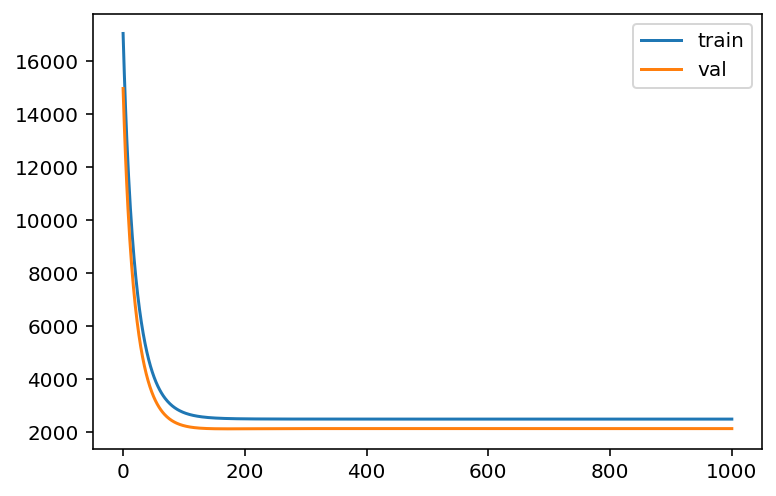

In [0]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

##2.5 예측하기

In [0]:
train.columns

Index(['hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm2.5', 'count'],
      dtype='object')

In [0]:
# 타겟 데이터인 count를 제외한 나머지 특징들로 test해보자
x_test = test[train.columns[:-1]]
x_test = x_test.apply(lambda x: (x - x.mean()) / x.std())
x_test = x_test.values
x_test = torch.tensor(x_test, dtype=torch.float)

In [0]:
prediction = model(x_test)
# prediction 은 tensor 값이므로 어레이 형식으로 바꿔준다.
prediction = prediction.detach().numpy()

##2.6 submission 만들기

In [0]:
submission = pd.DataFrame(data=prediction, columns=['count'])
submission['id'] = test['id']
submission = submission.set_index('id')
submission.to_csv('my_submission.csv', index=True)

##2.7 랜덤포레스트랑 비교하기

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor

model_forest = RandomForestRegressor(random_state=42)
model_forest.fit(x_train, y_train)

y_val_pred = model_forest.predict(x_val)

from sklearn.metrics import mean_squared_error
MSE_forest = mean_squared_error(y_val, y_val_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


In [0]:
print(f'MSE_forest : {MSE_forest}, MSE_mymodel : {cost.item()}')

MSE_forest : 1355.9197788194444, MSE_mymodel : 2129.544677734375
